In [37]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from keras.models import Sequential
from keras import layers
from keras.layers import Embedding

import seaborn as sns
sns.set(style = 'whitegrid')

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from sklearn.metrics import classification_report, confusion_matrix

In [38]:
df = pd.read_csv('../Clean_Dataset.csv', encoding='UTF-8')
#df2 = pd.read_csv('../Additional_Dataset.csv', encoding='UTF-8')

In [3]:
'''
print(df.shape)
print(df2.shape)
'''

'\nprint(df.shape)\nprint(df2.shape)\n'

In [4]:
#df = df.append(df2, ignore_index=True)

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_17380\445450659.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df2, ignore_index=True)


In [5]:
#df.to_csv('../Cleaning/Combine_Dataset.csv')

In [39]:
train = df[['Clean_Text','Stop_Words_Text', 'Stemmed_Text', 'indonlp_sentiment', 'Lexicon_Score']]

#### Data Preprocessing

In [40]:
data = df['Clean_Text'].values.tolist()

In [41]:
print(data[:5])

['cina dan as terus bersaing mengembangkan teknologi terbaru termasuk kali ini perusahaan di kedua negara berlomba lomba membangun dunia virtual atau metaverse', 'katanya mau metaverse tapi down melulu bagaimana mas zuck', 'mungkin facebook sudah berencana menjadi metaverse besar secara sudah menyiapkan diem sebagai stable curency mereka kalau emang iya pasti nanti pindah ke blokchain semua facebook masih menang banyak karena hanya memerlukan pembaruan teknologi penggunanya sudah banyak', 'bersaing dengan perusahaan kelas dunia untuk mencapai hal ini sektor publik dan swasta harus bersatu untuk membentuk ekosistem metaverse yang melibatkan teknologi ar vr dan xr dalam forum tersebut juga dibahas bagaimana mensukseskan platform ini dengan pasar konsumen', 'metaverse belum diadaptasi masif masih terus dikembangkan nyatanya hari ini kita kadang sudah bingung ujung pangkal dari persinggugangan realita empiris dan realita artifisial waw']


### Building a Model

#### Label Encoding of Output

In [43]:
import tensorflow as tf
labels = np.array(train['indonlp_sentiment'])
y = []
for i in range(len(labels)):
    if labels[i] == 'neutral':
        y.append(0)
    if labels[i] == 'negative':
        y.append(1)
    if labels[i] == 'positive':
        y.append(2)
y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 3, dtype="float32")
del y

##### Bag of Words (BOW) feature extraction

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.feature_extraction-text import TfidVectorizer

vocabulary_size = 50000 

#to preprocessor & tokenizer step
count_vector = CountVectorizer(max_features=vocabulary_size,
#                               ngram_range=(1,2),    # unigram and bigram
                                preprocessor=lambda x: x,
                               tokenizer=lambda x: x) 
#tfidf_vector = TfidfVectorizer(lowercase=True, stop_words='indonesian')

# Fit the training data
X_train = count_vector.fit_transform(X_train).toarray()

# Transform testing data
X_test = count_vector.transform(X_test).toarray()

#### Tokenizing and Adding Padding

In [42]:
max_words = 50000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[    0     0     0 ...    30    44     1]
 [    0     0     0 ...    62   220  1547]
 [    0     0     0 ...  1596    10    47]
 ...
 [    0     0     0 ...  2032    42  3087]
 [    0     0     0 ...  1951   735 15686]
 [    0     0     0 ...   199     2   638]]


42404

#### Split Dataset

In [44]:
X_train, X_test, y_train, y_test = train_test_split(tweets, labels, test_size = 0.2, random_state = 42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(33923, 100) (33923, 3)
(8481, 100) (8481, 3)


#### Using BiDirectional and LSTM

In [45]:
model2 = Sequential()
model2.add(layers.Embedding(max_words, 40, input_length=max_len))
model2.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model2.add(layers.Dense(3,activation='softmax'))
model2.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

#### Train the Model

In [13]:
history = model2.fit(X_train, y_train, epochs=10,validation_split=0.2)

Epoch 1/10
1079/1079 [==============================] - 87s 73ms/step - loss: 0.6458 - accuracy: 0.7234 - val_loss: 0.4916 - val_accuracy: 0.8018
Epoch 2/10
1079/1079 [==============================] - 76s 71ms/step - loss: 0.4178 - accuracy: 0.8345 - val_loss: 0.4633 - val_accuracy: 0.8116
Epoch 3/10
1079/1079 [==============================] - 75s 70ms/step - loss: 0.3227 - accuracy: 0.8754 - val_loss: 0.4868 - val_accuracy: 0.8086
Epoch 4/10
1079/1079 [==============================] - 75s 70ms/step - loss: 0.2689 - accuracy: 0.8977 - val_loss: 0.5240 - val_accuracy: 0.7961
Epoch 5/10
1079/1079 [==============================] - 74s 69ms/step - loss: 0.2294 - accuracy: 0.9139 - val_loss: 0.5481 - val_accuracy: 0.8037
Epoch 6/10
1079/1079 [==============================] - 72s 67ms/step - loss: 0.1988 - accuracy: 0.9239 - val_loss: 0.5641 - val_accuracy: 0.8023
Epoch 7/10
1079/1079 [==============================] - 70s 65ms/step - loss: 0.1810 - accuracy: 0.9316 - val_loss: 0.6229 -

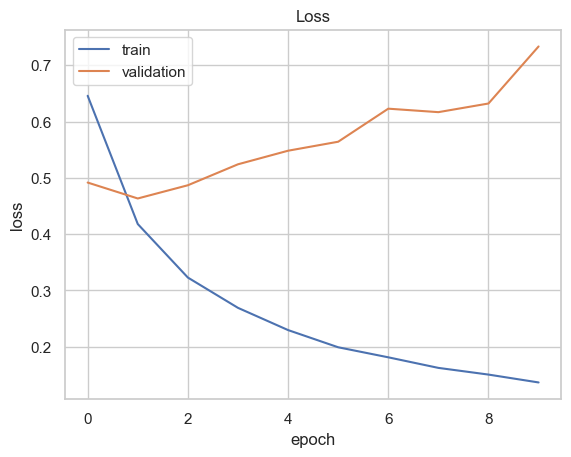

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

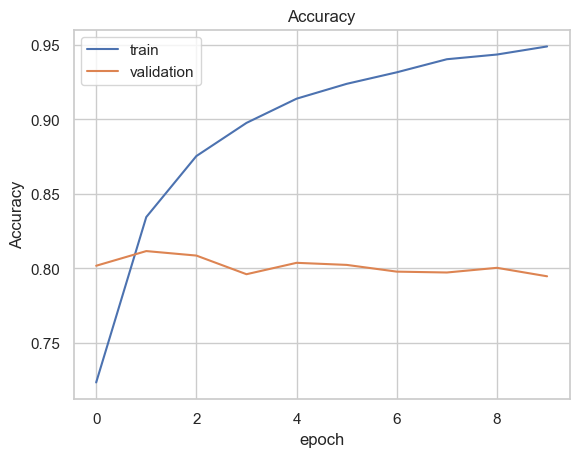

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

337/337 [==============================] - 7s 13ms/step
Model Accuracy on Test Data: 0.796809793192989


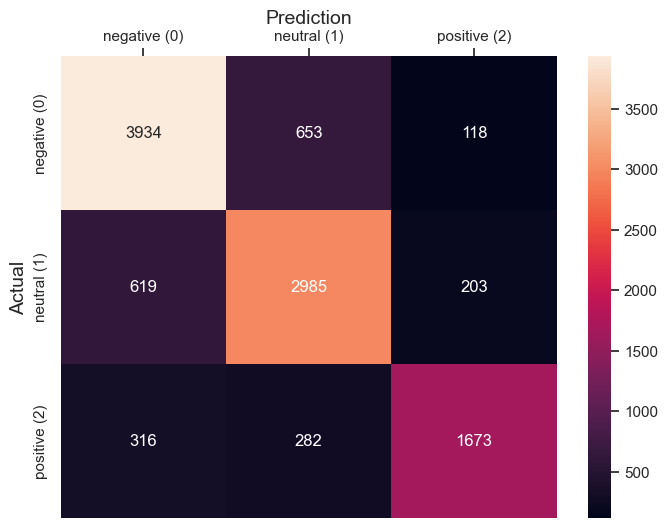

In [16]:
# Predict sentiment on data test by using model has been created, and then visualize a confusion matrix
y_pred = np.argmax(model2.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
accuracy = accuracy_score(y_true, y_pred)
print('Model Accuracy on Test Data:', accuracy)
confusion_matrix(y_true=y_true, y_pred=y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(confusion_matrix(y_true=y_true, y_pred=y_pred), fmt='g', annot=True)
ax.xaxis.set_label_position('top')
ax.xaxis.set_ticks_position('top')
ax.set_xlabel('Prediction', fontsize=14)
ax.set_xticklabels(['negative (0)', 'neutral (1)', 'positive (2)'])
ax.set_ylabel('Actual', fontsize=14)
ax.set_yticklabels(['negative (0)', 'neutral (1)', 'positive (2)'])
plt.show()


In [17]:
# predict classes for test set
y_pred = np.argmax(model2.predict(X_test), axis=-1)

# convert one-hot encoded true labels to integer class labels
y_test_int = np.argmax(y_test, axis=1)

# calculate metrics
print(classification_report(y_test_int, y_pred))

# calculate confusion matrix
conf_mat = confusion_matrix(y_test_int, y_pred)
print(conf_mat)


337/337 [==============================] - 4s 11ms/step
              precision    recall  f1-score   support

           0       0.81      0.84      0.82      4705
           1       0.76      0.78      0.77      3807
           2       0.84      0.74      0.78      2271

    accuracy                           0.80     10783
   macro avg       0.80      0.79      0.79     10783
weighted avg       0.80      0.80      0.80     10783

[[3934  653  118]
 [ 619 2985  203]
 [ 316  282 1673]]


#### Prediction and Result

In [18]:
sentiment = ['Neutral', 'Negative', 'Positive']

In [19]:
sequence = tokenizer.texts_to_sequences(['metaverse teknologi yang sangat buruk'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model2.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 33ms/step


'Negative'

In [20]:
sequence = tokenizer.texts_to_sequences(['wow metaverse teknologi yang sangat menjanjikan'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model2.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 39ms/step


'Positive'

In [21]:
sequence = tokenizer.texts_to_sequences(['kita lihat saja bagaimana perkembangan teknologi tersebut'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model2.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 37ms/step


'Neutral'

#### Building Model again with some Regularization

In [60]:
model = Sequential()
model.add(layers.Embedding(max_words, 40, input_length=max_len))
model.add(layers.BatchNormalization())
model.add(layers.Bidirectional(layers.LSTM(15,dropout=0.6)))
model.add(layers.Dense(3,activation='softmax'))
model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

In [61]:
history2 = model.fit(tweets, labels, epochs=20,validation_split=0.2)

Epoch 1/20
1061/1061 [==============================] - 68s 54ms/step - loss: 0.7554 - accuracy: 0.6762 - val_loss: 0.6126 - val_accuracy: 0.7655
Epoch 2/20
1061/1061 [==============================] - 56s 53ms/step - loss: 0.6126 - accuracy: 0.7475 - val_loss: 0.5778 - val_accuracy: 0.7803
Epoch 3/20
1061/1061 [==============================] - 56s 53ms/step - loss: 0.5656 - accuracy: 0.7683 - val_loss: 0.5490 - val_accuracy: 0.7932
Epoch 4/20
1061/1061 [==============================] - 56s 53ms/step - loss: 0.5382 - accuracy: 0.7811 - val_loss: 0.5663 - val_accuracy: 0.7939
Epoch 5/20
1061/1061 [==============================] - 55s 52ms/step - loss: 0.5110 - accuracy: 0.7938 - val_loss: 0.5535 - val_accuracy: 0.7951
Epoch 6/20
1061/1061 [==============================] - 55s 52ms/step - loss: 0.4912 - accuracy: 0.8041 - val_loss: 0.5349 - val_accuracy: 0.8008
Epoch 7/20
1061/1061 [==============================] - 56s 53ms/step - loss: 0.4750 - accuracy: 0.8104 - val_loss: 0.5423 -

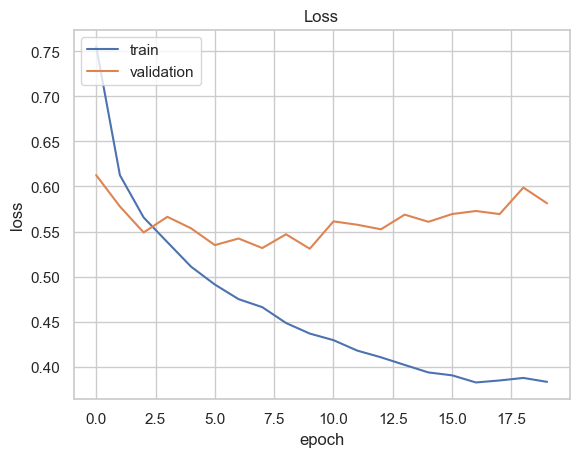

In [62]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

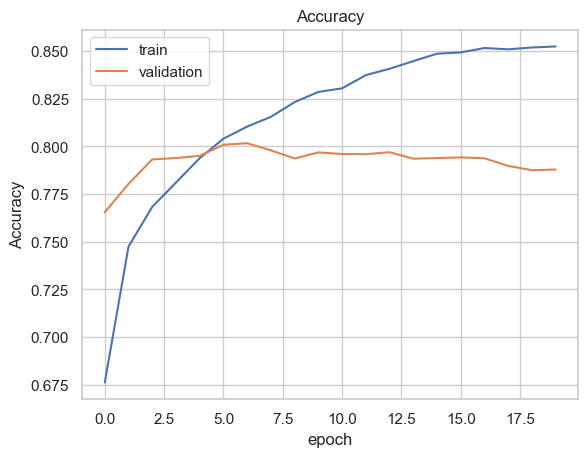

In [63]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

266/266 [==============================] - 4s 9ms/step
Model Accuracy on Test Data: 0.8609833746020517


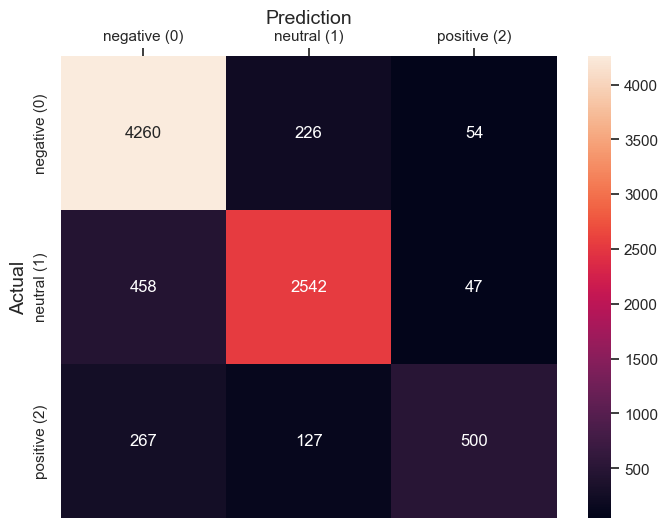

In [64]:
# Predict sentiment on data test by using model has been created, and then visualize a confusion matrix
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
accuracy = accuracy_score(y_true, y_pred)
print('Model Accuracy on Test Data:', accuracy)
confusion_matrix(y_true=y_true, y_pred=y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(confusion_matrix(y_true=y_true, y_pred=y_pred), fmt='g', annot=True)
ax.xaxis.set_label_position('top')
ax.xaxis.set_ticks_position('top')
ax.set_xlabel('Prediction', fontsize=14)
ax.set_xticklabels(['negative (0)', 'neutral (1)', 'positive (2)'])
ax.set_ylabel('Actual', fontsize=14)
ax.set_yticklabels(['negative (0)', 'neutral (1)', 'positive (2)'])
plt.show()

In [65]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# predict classes for test set
y_pred = np.argmax(model.predict(X_test), axis=-1)

# convert one-hot encoded true labels to integer class labels
y_test_int = np.argmax(y_test, axis=1)

# calculate metrics
print(classification_report(y_test_int, y_pred))

# calculate confusion matrix
conf_mat = confusion_matrix(y_test_int, y_pred)
print(conf_mat)


266/266 [==============================] - 3s 9ms/step
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      4540
           1       0.88      0.83      0.86      3047
           2       0.83      0.56      0.67       894

    accuracy                           0.86      8481
   macro avg       0.85      0.78      0.81      8481
weighted avg       0.86      0.86      0.86      8481

[[4260  226   54]
 [ 458 2542   47]
 [ 267  127  500]]


In [66]:
sequence = tokenizer.texts_to_sequences(['metaverse itu bahasa yahudinya aku cinta israel'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model2.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 1s 1s/step


'Neutral'

In [67]:
sequence = tokenizer.texts_to_sequences(['itu kategori metaverse ya yang menang lalisa takes over vmas'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model2.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 32ms/step


'Neutral'

In [68]:
sequence = tokenizer.texts_to_sequences(['teknologi yang sangat menjanjikan'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model2.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 31ms/step


'Neutral'